# Survival analysis with GNN and Cox Model
In this notebook, we implement the whole pipeline to make survival analysis with Cox Model and GNN.

## Pipeline description
0. Reading dataset, drop censored patients, and label patients.
1. Build the graph to connect samples
2. Train the GNN for binary survival classification (event / no event) to learn the patients embeddings
3. Extract learnt patients embeddings
4. Train the Cox Model with new patients embeddings to predict survival metrics

In [251]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from models.BuildGraph import BuildGraph
from models.GCNClassifier import GCNClassifier
from manage.GCNTrainTestManager import GCNTrainTestManager
from models.CoxModel import CoxModel
from torch_geometric.utils import from_networkx

## 0. Reading dataset and drop censored patients
We use the dataset from the following article : https://doi.org/10.1158/1078-0432.CCR-20-1163. We drop the non naive patients.

In [252]:
df = pd.read_excel('data/Supplemental-table1.xlsx')

# Delete non naive patients
df = df.loc[df["Cohort"] == "Naive"]

df

,Anonymous ID,EGA ID,Tumour type,Sex,Line of therapy,Immunotherapy regimen,Cohort,Reason for discontinuation,Best response,Age at advanced disease diagnosis,...,Alive_0,Time to progression (days),Progression_1,Clinical benefit,CD8+ T cell score,Exome mut per mb,Genome mut per mb,CD274 expression,M1M2 expression,Lymph related
0,14891,EGAD00001001961,LUNG,F,8,Nivolumab,Naive,Progression,Mixed,45,...,1,179,1,NCB,0.351869,11.095310,23.0729,4.1689,55.51575,Non-lymph related
1,18624,EGAD00001002047,AECA,F,10,Nivolumab,Naive,Progression,Stable disease,47,...,1,148,1,NCB,0.071464,3.876336,5.4552,0.7910,9.32352,Non-lymph related
2,21392,EGAD00001002544,OV,F,6,Monalizumab,Naive,Progression,Physician assessed SD,57,...,1,79,1,NCB,0.040394,2.415688,4.1274,4.0377,50.12008,Lymph related
3,21516,EGAD00001002546,SKCM,F,3,Ipilimumab,Naive,Death,Not evaluable,29,...,1,11,0,NCB,0.052774,6.235845,11.4871,0.6006,1.58550,Non-lymph related
4,22186,EGAD00001001966,LUNG,F,4,Atezolizumab,Naive,Progression,Stable disease,52,...,1,80,1,NCB,0.009323,4.606660,7.1503,1.8234,38.42695,Non-lymph related
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
92,39280,EGAD00001004933,LUNG,M,2,Pembrolizumab,Naive,Toxicity,Physician Assessed SD,60,...,1,401,0,DCB,0.695396,84.998501,96.4079,8.4768,86.62561,Non-lymph related
94,37899,EGAD00001005838,CHOL,F,2,Nivolumab,Naive,Death,Physician assessed PR,38,...,1,96,0,NCB,0.818233,2.247151,2.7416,11.2704,47.97376,Non-lymph related
95,37775,EGAD00001004934,HNSC,M,1,Avelumab/OX40 agonist PF-04518600,Naive,Progression,Stable disease,69,...,1,69,1,NCB,0.018982,3.848247,5.8036,8.7136,5.13403,Non-lymph related
96,38313,EGAD00001005844,ACC,F,3,Avelumab/Debio1143 (SMAC mimetic),Naive,Toxicity,Partial response,34,...,1,51,1,NCB,0.000000,5.617878,7.7940,0.0688,0.51364,Non-lymph related


### Delete censored patients
In statistics, some patients can have non faithful metrics, because of leaving the study for example. In our context, we want to drop patients which have not experienced an event (status = 0) and where the time of event is less than a given time t (which represents the time when we look at). Indeed, it might represent a precocious leaving of the patient ; what happened between the time of leaving and the time t when we look at ?

In [253]:
def drop_censored_patients(df: pd.DataFrame, status_name: str, time_name: str, t: float)->pd.DataFrame:
    """ 
    Delete censored patients from the initial dataframe. A censored patient is a patient with status = 0 and time_event < t.

    ### Parameters :
    - df : the dataframe to update
    - status_name : the name of the status event column in the dataframe
    - time_name : the name of the time event column in the dataframe
    - t : the time when we look at (threshold).

    ### Returns :
    The dataframe without censored patients.
    """

    # Get index of to drop patients
    to_drop = df.index[np.where((df[status_name] == 0) & (df[time_name]<t))[0]]
    print(f"{to_drop.shape[0]} patients censored deleted")

    # Update dataframe
    df_non_censored = df.drop(to_drop,axis=0)

    return df_non_censored

In [254]:
## TTP (Time To Progression)
t_ttp = np.median(df["Time to progression (days)"].to_numpy())
df_ttp_non_censored = drop_censored_patients(df, "Progression_1", "Time to progression (days)", t_ttp)

## OS (Overall survival)
t_os = np.median(df["Overall survival (days)"].to_numpy())
df_os_non_censored = drop_censored_patients(df, "Alive_0", "Overall survival (days)", t_os)

6 patients censored deleted
1 patients censored deleted


### Label patients for future classification
Now, we want to create a label column to split event occured patients and no event occured patients : 
- status = 1 and time < t : class 1 (the event occured)
- status = 1 and time > t : class 0 (the event has not occured yet at the time when we look at. The event will occur later)
- status = 0 and time > t : class 0 (the event has not occured at the time when we look at)
- status = 0 and time < t : censored patients, we already dropped these patients.

Because we already dropped censored patients, we can see that we just have to test if time < t. If yes, we label 1, otherwise, we label 0.

In [255]:
def label_patients(df: pd.DataFrame, time_name: str, t: float)->pd.DataFrame:
    """ 
    Create new column in dataframe with event label depending on status, time and t values.

    ### Parameters :
    - df : the dataframe to update
    - status_name : the name of the status event column in the dataframe
    - time_name : the name of the time event column in the dataframe
    - t : the time when we look at (threshold).

    ### Returns :
    The dataframe with an extra label column.
    """
    
    # We test if time < t (1 if yes, 0 otherwise)
    df["event_occured"] = np.where(df[time_name]<t, 1, 0)
    
    return df

In [256]:
## TTP :
df_ttp_non_censored = label_patients(df_ttp_non_censored, "Time to progression (days)",t_ttp)

## OS :
df_os_non_censored = label_patients(df_os_non_censored, "Overall survival (days)",t_os)

## 1. Build the graph to connect patients
For now, we gather patients with the same tumour type, and, for each tumour type, all patients are inter-connected.

In [257]:
## TTP :
buildgraph_ttp = BuildGraph(df_ttp_non_censored)

## OS :
buildgraph_os = BuildGraph(df_os_non_censored)

### Create adjacency matrix
If 2 patients have the same tumour type, we put 1 if the corresponding case in adjacency matrix. Otherwise, we put 0.

In [258]:
## TTP :
buildgraph_ttp.compute_adjacency_matrix("Tumour type")

## OS :
buildgraph_os.compute_adjacency_matrix("Tumour type")

### Create the graph from adjacency matrix
Each node of the graph contains its features and its label. Then, with the adjacency matrix, we connect nodes. The resulting graph is under networkx format. 

In [259]:
# Name of the features for each node
features_name = ["CD8+ T cell score","Exome mut per mb"]

# Name of the label for each node
label_name = "event_occured"

## TTP :
buildgraph_ttp.create_graph(features_name, label_name)

## OS :
buildgraph_os.create_graph(features_name, label_name)

### Vizualize the graph
Let's see what our graphs look like.

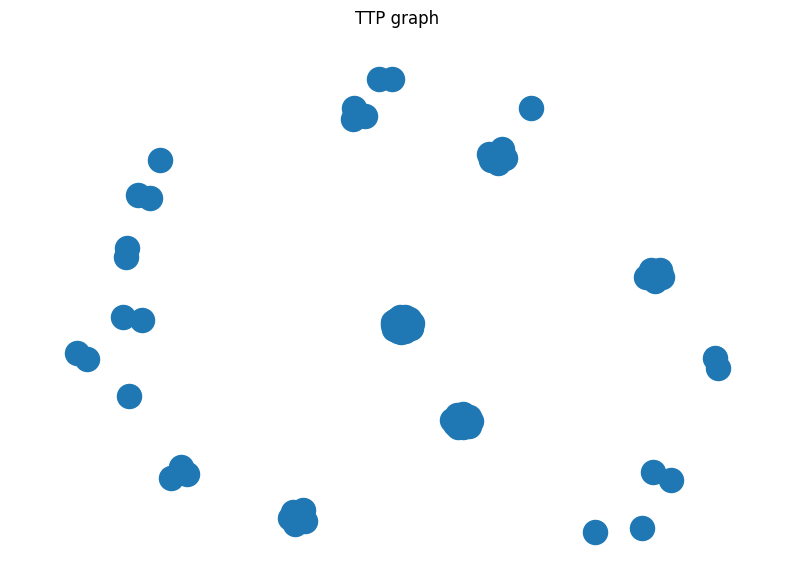

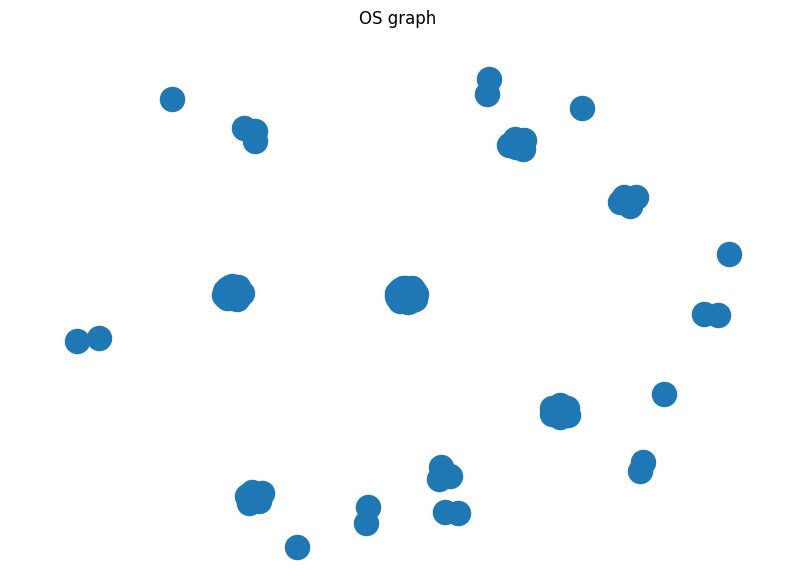

In [260]:
## TTP :
buildgraph_ttp.show_graph("TTP graph","ttp-graph.png")

## OS :
buildgraph_os.show_graph("OS graph","os-graph.png")

### Convert the graph into PyTorch Geometric format
For the following section, we need to convert the networkx graph to a PyTorch geometric one.

In [261]:
## TTP :
pyg_graph_ttp = from_networkx(buildgraph_ttp.G)

## OS :
pyg_graph_os = from_networkx(buildgraph_os.G)

## 2. Train the GNN for binary survival classification
Now, we want to learn the patients embeddings. Because a library which learns the Cox parameters and GNN parameters does not exist, we need to split the process in 2 steps : first, learn the GNN parameters for the equivalent classification problem, and then, use the learnt embeddings to make the Cox regression. Here, we are at step 1.

In [262]:
## TTP :
gcn_classifier_ttp = GCNClassifier(num_features=len(features_name))

## OS :
gcn_classifier_os = GCNClassifier(num_features=len(features_name))

### Define training loss and optimizers, and instanciate train managers
We use the Binary Cross Entropy Loss, and the Adam optimizer. 

In [263]:
# Loss :
loss_function_ttp = torch.nn.BCELoss()
loss_function_os = torch.nn.BCELoss()

# Optimizer :
optimizer_ttp = torch.optim.Adam(gcn_classifier_ttp.parameters(), lr=0.01)
optimizer_os = torch.optim.Adam(gcn_classifier_os.parameters(), lr=0.01)

In [264]:
## TTP : 
train_manager_ttp = GCNTrainTestManager(gcn_classifier_ttp, pyg_graph_ttp, loss_function_ttp, optimizer_ttp)

## OS :
train_manager_os = GCNTrainTestManager(gcn_classifier_os, pyg_graph_os, loss_function_os, optimizer_os)

### Training

In [265]:
## TTP :
train_manager_ttp.train(n_epochs=100)

Epoch 1 of 100
Epoch 11 of 100
Epoch 21 of 100
Epoch 31 of 100
Epoch 41 of 100
Epoch 51 of 100
Epoch 61 of 100
Epoch 71 of 100
Epoch 81 of 100
Epoch 91 of 100
End of training.


In [266]:
## OS :
train_manager_os.train(n_epochs=100)

Epoch 1 of 100
Epoch 11 of 100
Epoch 21 of 100
Epoch 31 of 100
Epoch 41 of 100
Epoch 51 of 100
Epoch 61 of 100
Epoch 71 of 100
Epoch 81 of 100
Epoch 91 of 100
End of training.


### Plot train loss

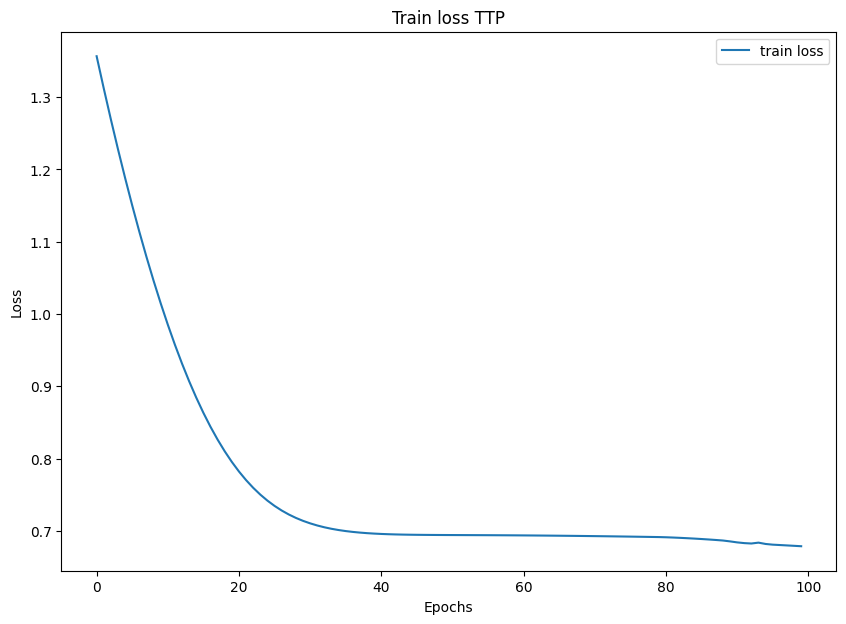

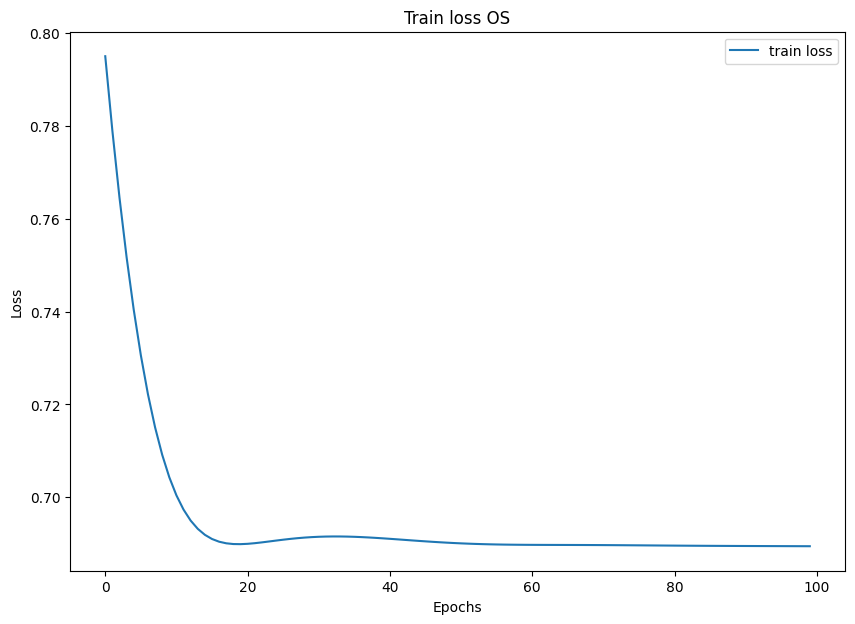

In [267]:
## TTP :
train_manager_ttp.plot_loss("Train loss TTP","train-loss-ttp.png")

## OS :
train_manager_os.plot_loss("Train loss OS","train-loss-os.png")

## 3. Extract learnt patients embeddings
With the previous section, we learnt parameters of GCN classifier. So we can extract new patients embeddings, where each patient has its features and the features of its neighbours. For that, we apply the convolutive layer in our GCN model.

In [268]:
## TTP : 
df_ttp_learnt = pd.DataFrame(gcn_classifier_ttp.forward_conv(pyg_graph_ttp.x, pyg_graph_ttp.edge_index).detach().numpy(), columns=features_name, index=df_ttp_non_censored.index)
print("Initial embeddings : ")
display(df_ttp_non_censored.loc[:,features_name])
print("New embeddings : ")
display(df_ttp_learnt)

Initial embeddings : 


,CD8+ T cell score,Exome mut per mb
0,0.351869,11.095310
1,0.071464,3.876336
2,0.040394,2.415688
4,0.009323,4.606660
6,0.351194,1.432559
...,...,...
92,0.695396,84.998501
94,0.818233,2.247151
95,0.018982,3.848247
96,0.000000,5.617878


New embeddings : 


,CD8+ T cell score,Exome mut per mb
0,-0.782453,1.943758
1,0.138739,0.137125
2,0.125326,0.097089
4,-0.782453,1.943758
6,-0.782453,1.943758
...,...,...
92,-0.782453,1.943758
94,0.837978,-0.292080
95,0.064901,0.535546
96,0.041123,0.235553


In [269]:
## OS : 
df_os_learnt = pd.DataFrame(gcn_classifier_os.forward_conv(pyg_graph_os.x, pyg_graph_os.edge_index).detach().numpy(), columns=features_name, index=df_os_non_censored.index)
print("Initial embeddings : ")
display(df_os_non_censored.loc[:,features_name])
print("New embeddings : ")
display(df_os_learnt)

Initial embeddings : 


,CD8+ T cell score,Exome mut per mb
0,0.351869,11.095310
1,0.071464,3.876336
2,0.040394,2.415688
3,0.052774,6.235845
4,0.009323,4.606660
...,...,...
92,0.695396,84.998501
94,0.818233,2.247151
95,0.018982,3.848247
96,0.000000,5.617878


New embeddings : 


,CD8+ T cell score,Exome mut per mb
0,2.296355,-4.471625
1,0.378678,-1.041390
2,0.301694,-0.901820
3,5.170947,-9.607937
4,2.296355,-4.471625
...,...,...
92,2.296355,-4.471625
94,0.798452,-1.809036
95,3.916579,-7.369605
96,0.454003,-1.173553


## 4. Train Cox Model with new embeddings
Now, we can integrate the new dataframe into a Cox Model. We use scikit survival, which implements a one layer perceptron Cox model. 

### Preprocessing data
We need to format features into numpy array, and to format labels into list of tuples (status, time).

In [270]:
## TTP :
X_ttp = df_ttp_learnt.to_numpy()
y_ttp = np.array(list((df_ttp_non_censored[['Progression_1','Time to progression (days)']].itertuples(index=False, name=None))),dtype=[('Progression_1', '?'), ('Time to progression (days)', '<f8')])

## OS :
X_os = df_os_learnt.to_numpy()
y_os = np.array(list((df_os_non_censored[['Alive_0','Overall survival (days)']].itertuples(index=False, name=None))),dtype=[('Alive_0', '?'), ('Overall survival (days)', '<f8')])

### Instanciate Cox model

In [271]:
## TTP :
cox_model_ttp = CoxModel()

## OS :
cox_model_os = CoxModel()

### Find risk class for each patient
First, we want to estimate the risk score of each patient, with the training of the Cox model. Next, we want to split patients in 2 groups : low risk and high risk (threshold = median risk). Then, we compare the 2 survival curves. It gives a measure of separation ability of our model. 

In [272]:
## TTP :
risk_classes_ttp, risk_scores_ttp = cox_model_ttp.leave_one_out_cross_validation(X_ttp,y_ttp)
print("TTP :")
print(f"n_samples high risk : {np.where(risk_classes_ttp==1)[0].shape[0]}")
print(f"n_samples low risk : {np.where(risk_classes_ttp==0)[0].shape[0]}")

## OS :
risk_classes_os, risk_scores_os = cox_model_os.leave_one_out_cross_validation(X_os,y_os)
print("OS :")
print(f"n_samples high risk : {np.where(risk_classes_os==1)[0].shape[0]}")
print(f"n_samples low risk : {np.where(risk_classes_os==0)[0].shape[0]}")

TTP :
n_samples high risk : 39
n_samples low risk : 37
OS :
n_samples high risk : 39
n_samples low risk : 42


### Estimate survival function for each risk class
We use the Kaplan Meier estimator to estimate the survival probability.

In [273]:
## TTP :
status_ttp, time_ttp = df_ttp_non_censored['Progression_1'].to_numpy().astype(bool), df_ttp_non_censored['Time to progression (days)'].to_numpy()
# Low risk class
status_low_ttp, time_low_ttp = status_ttp[np.where(risk_classes_ttp==0)], time_ttp[np.where(risk_classes_ttp==0)]
time_axis_low_ttp, prob_axis_low_ttp = cox_model_ttp.kaplan_meier_estimation(status_low_ttp, time_low_ttp)
# High risk class
status_high_ttp, time_high_ttp = status_ttp[np.where(risk_classes_ttp==1)], time_ttp[np.where(risk_classes_ttp==1)]
time_axis_high_ttp, prob_axis_high_ttp = cox_model_ttp.kaplan_meier_estimation(status_high_ttp, time_high_ttp)

## OS :
status_os, time_os = df_os_non_censored['Alive_0'].to_numpy().astype(bool), df_os_non_censored['Overall survival (days)'].to_numpy()
# Low risk class
status_low_os, time_low_os = status_os[np.where(risk_classes_os==0)], time_os[np.where(risk_classes_os==0)]
time_axis_low_os, prob_axis_low_os = cox_model_os.kaplan_meier_estimation(status_low_os, time_low_os)
# High risk class
status_high_os, time_high_os = status_os[np.where(risk_classes_os==1)], time_os[np.where(risk_classes_os==1)]
time_axis_high_os, prob_axis_high_os = cox_model_os.kaplan_meier_estimation(status_high_os, time_high_os)

### Estimate C index :
In this context, the concordance index measures the proportion of patients comparable pairs in which the risk score and the surviving time are concordant.

In [274]:
## TTP : 
c_index_ttp = cox_model_ttp.get_c_index(status_ttp, time_ttp, risk_scores_ttp)
print(f"C index (TTP) : {c_index_ttp}")

## OS :
c_index_os = cox_model_os.get_c_index(status_os, time_os, risk_scores_os)
print(f"C index (OS) : {c_index_os}")

C index (TTP) : 0.52
C index (OS) : 0.53


### Estimate log rank test p value
The log rank test compares 2 survival curves. If the p value is low (under 5%), the 2 curves are different. Otherwise, the 2 curves are pretty similar. We make this test for the low risk (class 0) and high risk curves (class 1).

In [275]:
## TTP :
p_value_ttp = cox_model_ttp.log_rank_test(status_ttp.astype(int), time_ttp, risk_classes_ttp)
print(f"p value (TTP) : {p_value_ttp}")

## OS :
p_value_os = cox_model_os.log_rank_test(status_os.astype(int), time_os, risk_classes_os)
print(f"p value (OS) : {p_value_os}")

p value (TTP) : 0.07
p value (OS) : 0.37


### Plot survival curves

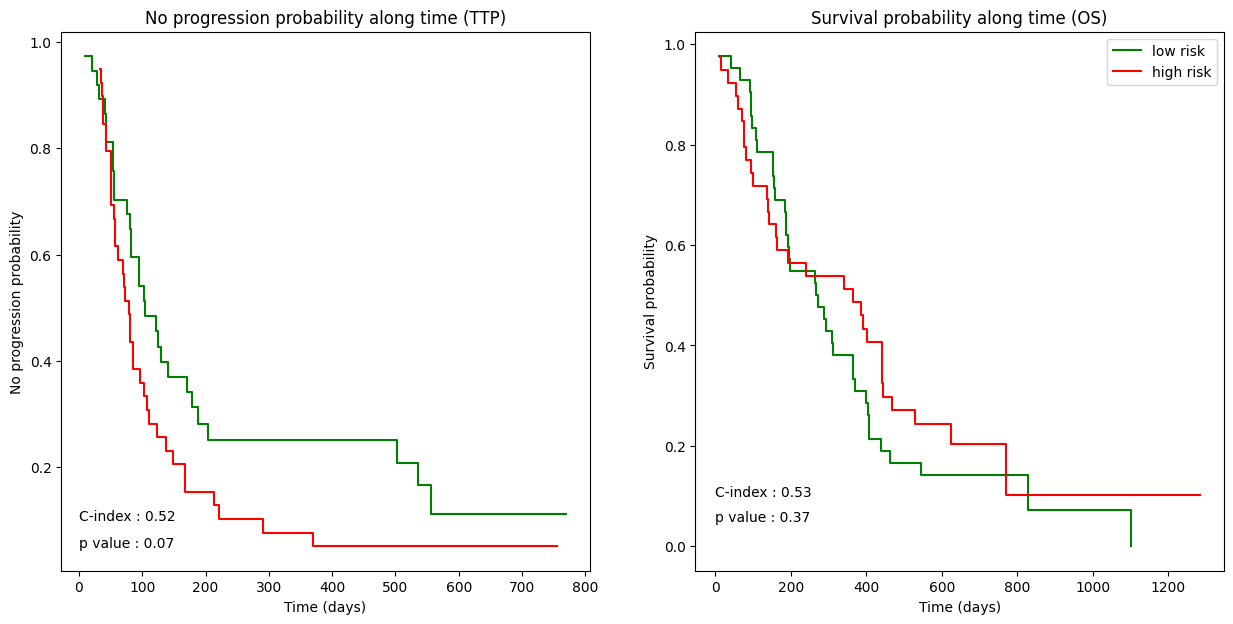

In [276]:
fig, ax = plt.subplots(1,2,figsize=(15,7))
ax[0].step(time_axis_low_ttp, prob_axis_low_ttp, where='post',color='green',label='low risk')
ax[0].step(time_axis_high_ttp, prob_axis_high_ttp, where='post',color='red',label='high risk')
ax[0].set_xlabel('Time (days)')
ax[0].set_ylabel('No progression probability')
ax[0].set_title('No progression probability along time (TTP)')
ax[0].text(0,0.1,f'C-index : {c_index_ttp}')
ax[0].text(0,0.05,f'p value : {p_value_ttp}')

ax[1].step(time_axis_low_os, prob_axis_low_os, where='post',color='green',label='low risk')
ax[1].step(time_axis_high_os, prob_axis_high_os, where='post',color='red',label='high risk')
ax[1].set_xlabel('Time (days)')
ax[1].set_ylabel('Survival probability')
ax[1].set_title('Survival probability along time (OS)')
ax[1].text(0,0.1,f'C-index : {c_index_os}')
ax[1].text(0,0.05,f'p value : {p_value_os}')

plt.legend()
plt.savefig('gnn-survival-curves.png')